Homework 2 — (20 points)
======
### What to hand in
You are to submit the following things for this homework:
1. A Jupyter notebook containing all code and output (figures and audio). I should be able to evaluate the file to reproduce all output. 
1. Any other data that we tell you to save to a file (e.g. audio files).

Note: Make sure to include all the files that are required for the notebook to run **from the submission folder** (e.g. police_noisy.wav). Points will be taken off from submissions that crash because Python cannot find the specified files.

### How to hand it in
To submit your lab:
1. Compress all of the files specified into a .zip file. 
1. Name the file in the following manner, firstname_lastname_hw1.zip. For example, Bryan_Pardo_hw1.zip. 
1. Submit this .zip file via Canvas

### Run this code block 1st, to import the needed packages

In [1]:
# This line is a convenience to import most packages you'll need. You may need to import others (e.g. random and cmath)
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, cmath,math
from IPython.display import Audio
 
# This line makes sure your plots happen IN the webpage you're building, instead of in separate windows.
%matplotlib inline

### Some useful code

####  STFT 

In [2]:
from scipy.fftpack import fft
from scipy.signal import hann

def stft(signal, window_size, hop_size, window_type = 'hann'):
    """
    Computes the short term fourier transform of a 1-D numpy array, where the array 
    is windowed into a set of subarrays, each of length window_size. The distance between
    window centers (in samples) is given by hop_size. The type of window applied is
    determined by window_type. This returns a 2-D numpy array where the ith column
    is the FFT of the ith window. Each column contains an array of complex values.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    window_type: a string specifying one of two "hann" or "rectangular"
    
    Returns
    -------
    a 2D numpy array of complex numbers where the array column is the FFT of the ith window,
    and the jth element in the ith column is the jth frequency of analysis.
    """
    
    # figure out how many hops
    length_to_cover_with_hops = len(signal) - window_size;
    assert (length_to_cover_with_hops >= 0), "window_size cannot be longer than the signal to be windowed"
    num_hops = int(1 + np.floor(length_to_cover_with_hops/hop_size));
    
    # make our window function
    if (window_type == 'hann'):
        window = sp.signal.hann(window_size, sym=False)
    else:
        window = np.ones(window_size) # rectangular window
    
    stft = [0]*num_hops
    # fill the array with values 
    for hop in range(num_hops):
        start = hop*hop_size
        end = start + window_size
        unwindowed_sound = signal[start:end]
        windowed_sound =  unwindowed_sound * window
        stft[hop]= fft(windowed_sound, window_size) 
    return np.array(stft).T

#### ISTFT

In [3]:
from scipy.fftpack import ifft

def istft(X, hop_size):
    """
    Takes a 2-D numpy array representing an STFT of some signal, where stft[i,j] is the jth
    frequency of analysis in the FFT of the ith window. 
    Performs an inverse FFT on each window and then does overlap & add resynthesis to rebuild 
    the original signal the STFT was built from.
    
    Input Parameters
    ----------------
    X: a 2-D numpy array of complex numbers representing an STFT, where the ith 
    column is the FFT of the ith window, and the jth row is the jth frequency of analysis.
        
    hop_size: an integer specifying the number of samples between the start of adjacent windows.
        
    Returns
    -------
    a 1-d numpy array of (possibly complex) values representing the original signal used to make X
    """
    
    # make an empty signal of the appropriate length
    window_size,num_hops = X.shape
    signal_length = (num_hops-1)*hop_size + window_size 
    signal = np.zeros(signal_length,dtype='complex');
    
    #fill the signal
    for n in range(num_hops):
        start = n * hop_size
        end = start + window_size
        signal[start:end] = signal[start:end] + ifft(X[:,n])
    return signal

In [4]:
# test the stft and istft functions
x = librosa.load('police_noisy.wav')[0]
winlen=1024 
hop=np.int(winlen/2)
X = stft(x,winlen, hop, window_type = 'hann')
x_rec = istft(X, hop)

min_len=min(len(x),len(x_rec))
# the signal is padded in the beginning and at the end and is not normalized either
# so the faded parts should be discarded in the error computation
print( 'reconstruction error: '+ str(np.sum(np.abs(x[hop:min_len-hop]-x_rec[hop:min_len-hop]))))


reconstruction error: 1.536696595616471e-11


#### Spectrogram (plotting function with zooming options)

In [5]:
def plt_spectrogram(X,win_length, hop_size, sample_rate, zoom_x=None, zoom_y=None,tick_labels='time-freq'):
    """
    Plots the log magnitude spectrogram.
    
    Input Parameters:
    ------------------
    X: 2D complex numpy array containing the stft values. Rows correspond to frequency bins and columns to time frames.
    win_length: the length of the analysis window
    hop_size: the hop size between adjacent windows
    sample_rate: sampling frequency
    tick_labels: the type of x and y tick labels, there are two options:
                 'time-freq': shows times (sec) on the x-axis and frequency (Hz) on the y-axis (default)
                 'bin-frame': shows time frame numbers on the x-axis and frequency bin numbers on the y-axis
                
    zoom_x: 1 by 2 numpy array containing the range of values on the x-axis, e.g. zoom_t = np.array([x_start,x_end])
    zoom_y: 1 by 2 numpy array containing the range of values on the y-axis, e.g. zoom_f = np.array([y_start,y_end])
    
    
    Returns:
    ---------
    times: 1D real numpy array containing time instances corresponding to stft frames
    freqs: 1D real numpy array containing frequencies of analyasis up to Nyquist rate
    2D plot of the magnitude spectrogram
    """
    
    # Find the size of stft
    Nf,Nt = np.shape(X)
    
    # Compute the log magnitude spectrogram
    X = 20*np.log10(np.abs(X))

    # Extract the lower half of the spectrum for each time frame
    X = X[0:int(Nf/2)+1] # make sure to include both 0 and Nyquist frequency
    Nf = np.shape(X)[0]
        
    # Generate time vector for plotting
    times = (hop_size/float(sample_rate))*np.arange(Nt)
    
    # Generate frequency vector for plotting
    freqs = (float(sample_rate)/win_length)*np.arange(Nf)
    
    # Generate time and frequency matrices for pcolormesh
    times_matrix,freqs_matrix = np.meshgrid(times,freqs)
    
    # Plot the log magnitude spectrogram
    plt.title('Log magnitude spectrogram')
    if tick_labels == 'bin-frame':
        plt.pcolormesh(X)
        plt.xlabel('Time-frame Number')
        plt.ylabel('Frequency-bin Number')
    else:
        plt.pcolormesh(times_matrix,freqs_matrix,X)
        plt.xlabel('Time (sec)')
        plt.ylabel('Frequency (Hz)')

        
    # Zoom in on the plot if specified
    if zoom_x is None and zoom_y is None:
        plt.axis('tight')
        
    if zoom_x is not None:
        plt.xlim(zoom_x)
        
    if zoom_y is not None:
        plt.ylim(zoom_y)
        
    return    

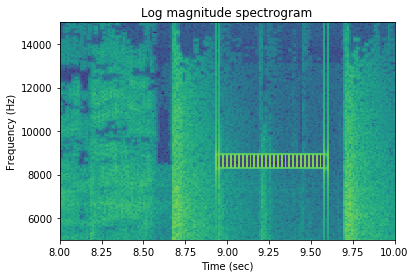

In [6]:
# test the plt-spectrogram fucntion
sr = 44100
x = librosa.load('police_noisy.wav',sr)[0]
winlen = 1024
hop = int(winlen/2)
X = stft(x,winlen, hop, window_type = 'hann')
plt_spectrogram(X,winlen,hop,sr,zoom_x=np.array([8,10]),zoom_y=np.array([5000,15000]),tick_labels='time-freq')


#### Autocorrelation function

In [7]:
def acorr(x):
    """
    Takes a 1D numpy array and returns the autocorrelation. 
    
    Input Parameter:
    ----------------
    x: 1D numpy array of length x_len
    
    Ouput Parameter:
    ----------------
    x_acorr: 1D numpy array of length x_len containing the values of the autocorrelation function of x
    
    Note: the actual length of autocorrelation function is (2*x_len)-1, but since this function is symmetric
          we can cut off (x_len)-1 samples and return one side of length x_len without losing information. 
    """
    
    x_len = np.size(x)
    x_pad = np.concatenate([x,np.zeros(x_len-1)])
    x_acorr = ifft(np.abs(fft(x_pad))**2).real
    x_acorr = x_acorr[0:x_len]
    
    x_acorr = x_acorr/(np.arange(x_len)[::-1]+1)  # normalize by the number of nonzero additions
            
    return x_acorr

# Questions from Week 3  (8 points)

### Note: For Questions 1 through 7, it is OK to use any function from librosa to do your work.


#### 1. (1 point) A balloon pop is an approximation of an impulse. A recording of a balloon pop in a room records what echo effects result from an impulse. It lets us estimate the room's impulse response.   The recordings "balloon_center.wav" and "balloon_stage.wav" are of balloon pops recorded in Ryan Auditorium.  The microphone was placed at the center of the auditorium. For the first recording, the balloon was popped very close to the microphone (balloon_center.wav). For the second one the balloon was popped on the stage, far from the microphone (balloon_stage.wav).

#### Assume that the balloon pops were perfect impulses and that the recordings made were perfect recordings of the resulting sound in the room. Explain how to use these recordings to estimate the impulse response of the room and how to add the sound of the auditorium's reverberation to the dry (no reverb) recording. 


######### need help #########
The impulse response of a system (e.g. a room) is the output of the system when an impulse is the input.
X[k]H[k] = Y[k] when there is no noise, N[k], present (i.e. perfect recording). The input (e.g. the balloon impulse in balloon_center.wav) is X[k], the impulse response of the system/room is H[k], and the sound of the impulse in the room (w/ response) is Y[k]. So, to get the impulse response of the room we have to set H[k] = Y[k]/X[k].

#### 2. (2 points) Write the code to add the sound of the auditorium's reverberation to the dry recording "trumpet.wav" using both recordings (we talked about two different methods for filtering a signal in class, use the one with less computational complexity). Listen to the results and discribe any similarities or differences you notice between the two reverbed sounds.

#### Make sure that you COMMENT YOUR CODE to explain each step of the algorithm.  If you don't comment, don't count on full points.

YOUR ANSWER HERE

In [ ]:
# your code goes here
'''
1. Estimate the impulse response using the method in Q1 and balloon_center.wav + balloon_stage.wav
2. Take the trumpet.wav file and perform convolution between it and the impulse response
'''

# load the audio time series' in 
balloon_center, b_c_sr = librosa.load("ryan_auditorium_recordings/balloon_center.wav")
balloon_stage, b_s_sr = librosa.load("ryan_auditorium_recordings/balloon_stage.wav")
trumpet, t_sr = librosa.load("trumpet.wav")

# slightly different signal lengths, this is shorter
balloon_len = len(balloon_stage)

# get the impulse response
ryan_impulse_response = balloon_stage/balloon_center[:balloon_len]
# print(ryan_impulse_response.shape)

# convolution code from the slides
# def convolution(A,B):
#     length_a = np.size(A)
#     length_b = np.size(B)
#     C = np.zeros(length_a + length_b - 1)
#     for m in np.arange(length_a):
#         for n in np.arange(length_b):
#             C[m+n] = C[m+n] + A[m]*B[n]
#     return C 

res = convolution(ryan_impulse_response, trumpet)
print(t_sr, b_c_sr)

# Audio("trumpet.wav")
# raise NotImplementedError # delete this line when you add your solution

#### 3. (1 points) Explain what possible sources of error there are that might mess up the approach you used on question 2 to estimating the auditorium's impulse  response. How you would go about reducing or eliminating these sources of error in your impulse response estimation?

YOUR ANSWER HERE

#### 4. (1 point)  Below is some code we have provided to estimate the impulse response of Ryan auditorium from the recording of a a sine sweep we played in Ryan auditorium. Plot the frequency response function associated with this impulse response function and plot the frequency response of the impulse response you got using the method in Question 1 in the code cell below the provided code. Compare them in the text cell below that. 

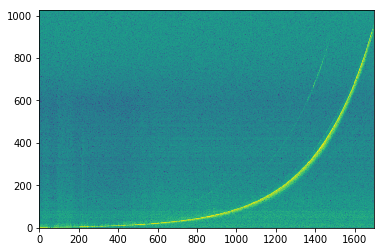

In [9]:
# load the original sine sweep that was played out through the speaker in the auditorium
sine_sweep,sr = librosa.load('sinesweep.wav', 44100)
input_size=np.size(sine_sweep)

# load the recording made of how the sine sweep sounded in the auditorium
sine_sweep_recording,sr = librosa.load('ryan_auditorium_recordings/sinesweep_recording.wav', 44100)
output_size = np.size(sine_sweep_recording)

# plot an stft of the sine sweep recorded in the auditorium
plt.figure(); plt.imshow(20*np.log10(np.abs(librosa.stft(sine_sweep_recording))),origin='lower',aspect='auto')

# calculate the response of the inverse filter which will be used to extract the impulse response of the auditorium
# from the sine sweep recording
freq_range = np.linspace(20,20000,input_size)
envelope = freq_range[::-1]**3; 
inv_filt = envelope*sine_sweep[::-1]
inv_filt = inv_filt/max(np.abs(inv_filt))

# compute the minimum number of fft point required for filtering (to avoid cirucular convolution)
nfft = input_size + output_size - 1
nfft = int(2**np.ceil(np.log2(nfft)))

# perform inverse filtering in the frequency domian 
inv_filt_fft = np.fft.fft(inv_filt,nfft)
recording_fft = np.fft.fft(sine_sweep_recording,nfft)
freq_response = inv_filt_fft*recording_fft
impulse_response = np.real(np.fft.ifft(freq_response))

# normalize the impulse response obtained through inverse filtering
impulse_response = impulse_response/max(np.abs(impulse_response))

# since the energy of the impulse response is concentrated at a very short duration (it's almost zero elsewhere)
# we need to trim it and extract the non-zero part

threshold = 0.005 # this threshold was selected empirically
nonzero_idx = np.nonzero(impulse_response>threshold) 
start = nonzero_idx[0][0] # the first time amplitude passes the threshold 
stop = start + sr  # the effective length of the impulse response seems to be less than one second 

impulse_response = impulse_response[start:stop]


In [ ]:
# your code goes here
raise NotImplementedError # delete this line when you add your solution


YOUR ANSWER HERE

#### 5. (1 point) Go on Youtube and listen to the musical piece "I am sitting in a room" by Alvin Lucier. Research the piece on the web. Give your reaction to the piece. Explain how it was created. 

Kind of weird to begin with. But a cool idea as he is explaining what he will do. About 9.5 minutes his words becomes unintelligible.
It was created by Alvin in a room. He first spoke into the room and recorded his words. He then played back the recording and recorded that. Then played that recording back and recorded that. He continued to do that over and over again until the words in the recording became impossible to hear and all you hear were drone-y tones and frequencies - the natural resonant frequencies of the room.

#### 6. A (1 point) Implement a function that applies an impulse response to a signal $n$ times, i.e. passes a signal $n$ times through a filter. You will use this function for recreating Lucier's piece, without having to play and re-record the signal over and over.

NOTE: you may have issues to deal with in terms of normalization or length of impulse response function vs length of the recording. You're going to have to figure out those out (read the notes in the function docstring carefully). 

In [ ]:
def reverbit(x, impulse_response, n):
    
    """
    Takes a time-domain signal x, applies the impulse_response to it n times and returns the output.
    
    Input Parameters
    ----------------
    x: 1D numpy array containing the time domain signal
    impulse_response: 1D numpy array containing the room impulse response
    n: integer, number of times to filter the signal with the room impulse response
                
    Returns
    -------
    x_filt: 1D numpy array that contains the signal with the impulse_response applied n times.  
    
    Notes:
    1. Remember that filtering can be done more efficiently in the frequency domain.
    2. If you choose to filter the signal in the frequency domain (recommended), to prevent distortion in the 
       filtered signal, for every iteration of filtering, you need to zero-pad both x and impulse 
       response to be of a minimum length of 
       L_pad = len(x) + len(impulse_response) - 1
       You should be able to figure out the minimum length required for n filtering iteration from this formula.
       Zero-padding can be done in the time domian by appending zeros at the end of the two signals. 
       Alternatively, you can use L_pad as an input to the fft function so that it does the zero-padding for you.
    3. The computational time of the fft function is greatly affected by the length of the input signal. The function
       is most efficient when the signal length is a power of 2, which is why we usually zero-pad input signals to 
       the next power 2 of their original length, e.g. if the signal length is 10, we zero-pad it to length 16. 
       So, after computing L_pad as described above, take one more step and find the next power 2 of L_pad and use it
       as input to the fft function. It will makes a big difference, especially for long signals.
           
    """
    # your code goes here
    raise NotImplementedError # delete this line when you add your solution
    

#### 7.  (1 point) Recreate Alvin Lucier's piece by recording your voice saying the text of the piece ONCE call that file *my-voice.wav*. Then repeatedly use an impulse response function (you can choose any of the provided impulse responses) applied to the signal, duplicating the effect of Lucier's piece without having to keep re-recording in the physical world.  In the code you submit below, have it  make and play the filter output for $n = 3$ applications of the filter. Also try running the filter for a larger value of $n$, where the effect of the filter becomes very strong.  In your submitted work, include wav files of your original recording (*my-voice.wav*) and the filter output for the largest value of $n$ you try (call it *lucier-max.wav*). In your anwer below, tell us what the value of $n$ was for lucier-max.wav and any issues you encountered.

YOUR ANSWER HERE

In [ ]:
# your code goes here
raise NotImplementedError # delete this line when you add your solution

# Questions from Week 4 (12 points)

### Time-Frequency Masking

#### 8. (1 point)  Load *police_noisy.wav*. The audio contains a ringing noise somewhere. Calculate the STFT of the audio signal, denoted by $X$ , using a hann window of length 2048 and 50% overlap between adjacent windows. Use the function plt_spectrogram provided above to plot the log magnitude spectrogram of the audio signal. Identify the region of the ringing noise. It should be a square of about 30 frequency bins by 30 time frames. Write down the frequency and time indices in your report. 

####  Note: we need to find the coordinates of the noisy region in terms of frequency bin number and time frame number, not in Hz and seconds. You can use the tick_labels parameter to set the values on the x-axis and y-axis to the required units. Moreover, zoom-x and zoom-y parameters can be set to narrower ranges in order to give better estimates of the region boundaries. Be careful about the consistency of zoom-x and zoom-y units with tick-labels.


In [ ]:
# here's where you show the two spectrograms and determine the region where the noise is
# your code goes here
raise NotImplementedError # delete this line when you add your solution

In [ ]:
noisy_region_freq = [0, 1] # fill this in with your final answer, 0 and 1 are dummy values
noisy_region_time = [0, 1] # fill this in with your final answer, 0 and 1 are dummy values
# your code goes here
raise NotImplementedError # delete this line when you add your solution

In [ ]:
# you don't need to put anything here, this cell is for this autograder

#### 9. (2 points) Use the frequency and time indices you found in Question 6 to create a simple binary time-frequency mask to apply to $X$ to remove the region of the ringing noise.  Plot the magnitude spectrogram of the denoised audio and check that the region of the ringing noise has been removed.  It wouldn't hurt to play it back for yourself, too.

#### Note, you need to derive a full time-frequency mask that masks out the frequency bins you saw in the spectrogram AND ALSO the "mirror image" frequency bins above the Nyquist frequency and apply it to the STFT of the noisy audio. Compute the denoised signal by tranforming the masked STFT, $X_{masked}$, back to the time domain.


In [ ]:
# your code goes here
raise NotImplementedError # delete this line when you add your solution

#### 10. (1 point) Explain why the applying a time-frequecy mask to the magnitude spectrogram instead of the STFT would not be a good idea.  

YOUR ANSWER HERE

### Beat Spectrum

#### 11. (1 point) Implement the beat spectrum. Use the autocorrelation function we provided you. Do not square the magnitude spectrogram within your function; it will be squared outside the function, in the *repet* function later in the homework. Do not normalize the output beat spectrum by the first element (lag 0) within your function; it will be normalized outside of the function, in the *repet* function. 

#### NOTE: At this point, it would be a VERY GOOD IDEA to make sure you actually read the [book chapter on REPET](http://music.cs.northwestern.edu/publications/Rafii-Liutkus-Pardo%20-%20REPET%20for%20Background-Foreground%20Separation%20in%20Audio%20-%20Springer%202014.pdf) 


In [ ]:
def beat_spectrum(V):
    """
    Computes the beat spectrum of a music mixture by applyting the autocorrelation to all frequency channels (rows)
    of the spectrogram and taking the average. Note that the assumption is that the mixture is composed of a repeating
    background and a non-repeating foreground. Therefore, the spikes in the beat spectrum represent the repetitive 
    events in the spectrogram.
    
    Input Parameter:
    ----------------
    V: 2D numpy array containing the magnitude spectrogram (i.e. the absolute values, not the complex) of a signal
    
    Output Parameter:
    ------------------
    beat_spec: 1D numpy array containing the beat spectrum 
    
    """
    # your code goes here
    raise NotImplementedError # delete this line when you add your solution

#### 12. (1 point) Apply the *beat_spectrum* function to the element-wise squared version of the magnitude spectrogram, $V^2$.  Plot the beat spectrum.  Explain how you would find the period of the repeating structure from the beat spectrum. Remember that the repeating period does not necessarily correspond to the first highest peak. Remember also that the beat spectrum goes from lag 0 to lag n-1, where n is the length of the input signal.

YOUR ANSWER HERE

In [ ]:
# your code goes here
raise NotImplementedError # delete this line when you add your solution

#### 13.  (2 points) Implement a repeating-segment modeling function (Hint: use the numpy *median* function). Note that after segmentation of the spectrogram, the last segment is generally shorter (in time frames) than the other segments, because the number of time frames is not necessarily an integer multiple of the repeating period; Think about how you would handle that.

#### NOTE: If you didn't take the hint on question 9, maybe now would be the time to read the [book chapter on REPET](http://music.cs.northwestern.edu/publications/Rafii-Liutkus-Pardo%20-%20REPET%20for%20Background-Foreground%20Separation%20in%20Audio%20-%20Springer%202014.pdf) 

In [ ]:
def repeating_segment(V,p):
    """
    Computes the repeating-segment model using the period obtained from the beat spectrum. 
    Once the repeating period p is estimated, we use it to segment the mixture spectrogram 
    V into r segments of length p. We then take the element-wise median of the r segments 
    and obtain the repeating segment model S. (See the course reading for more detail)
    
    Input Parameters:
    -----------------
    V: 2D numpy array containing the magnitude spectrogram of the mixture
    p: scalar, repeating period (in number of time steps) found from the beat spectrum 
    
    Output Parameter:
    S: 2D numpy array containing the repeating segment 
    """  
    # your code goes here
    raise NotImplementedError # delete this line when you add your solution

In [ ]:
# Test the function
S = repeating_segment(V,88)   
plt.figure()
plt.pcolormesh(10*np.log10(S))
plt.axis('tight')

#### 14. (1 point) Implement a repeating spectrogram modeling function (Hint: use the min function). Remember, the last segment in your spectrogram is generally shorter than the repeating segment model. 

In [ ]:
def repeating_spectrogram(V,S):
    """
    Once the repeating segment model S is calculated, we use it to derive a repeating spectrogram model W, 
    by taking the element-wise minimum between S and each of the r segments of the mixture spectrogram V.
    See the course reading on REPET for more details of what to do here.
    
    Input Parameters:
    -----------------
    V: 2D numpy array containing the magnitude spectrogram of the mixture
    S: 2D numpy array containing the repeating segment model 
    
    Output Parameter:
    ------------------
    W: 2D numpy array containing the repeating-spectrogram 
    """
    # your code goes here
    raise NotImplementedError # delete this line when you add your solution

In [ ]:
# Test the function
W=repeating_spectrogram(V,S)   
plt.figure()
plt.pcolormesh(10*np.log10(W))
plt.axis('tight')

#### 15. (1 point) Implement a repeating-mask modeling function (Hint: use  division). Note that there could be zero values in your spectrogram. Think about how to handle that. 

In [ ]:
def repeating_mask(V,W):
    """
    Computes the repeating mask from the magnitude spectrogram and the repeating spectrogram. Note that unlike the 
    denoising case in the first question, here we are computing a "soft mask" with values ranging between 0 and 1.
    
    Input Parameters:
    -----------------
    V: numpy 2D array containing the magnitude spectrogram 
    W: numpy 2D array containing the repeating spectrogram
    
    Output Parameter:
    M: numpy 2D array containing the repeating mask 
    """
    # your code goes here
    raise NotImplementedError # delete this line when you add your solution




In [ ]:
# Test the function
soft_mask = repeating_mask(V,W)
plt.figure()
plt.pcolormesh(soft_mask)
plt.axis('tight')

### Music-voice Separation with REPET

In [ ]:
def repet(file_path, rep_period, mask_thr):
    """
    Runs the REPET algorithm using functions implemented in qustions 3 through 8. 
    
    Input Parameters:
    ------------------
    file_path: string, path to the audio file to separate
    rep_period: scalar, repeating period in number of samples
    mask_thr: scalar, a value between 0 and 1 for thresholding the soft mask
    
    Plots:
    --------
    Separated background and foreground magnitude spectrogram plots 
    
    Returns: 
    ---------
    Separated background and foreground time signals
    """
    
    # Load the noisy mixture
    signal, sample_rate = librosa.load(file_path, 44100) 

    # Comput the stft of the audio signal 
    win_length_sec = 0.04 # 40 msec window
    win_length_samp = int(2**np.ceil(np.log2(win_length_sec*sample_rate))) # next power2 of winow length in no. of samples
    n_fft = win_length_samp
    hop_size = np.int(win_length_samp/2) # 50% overlap
    win_type = sp.signal.hanning
    X = stft(signal, win_length_samp, hop_size, window_type = 'hann')

    # Compute the magnitude spectrogram (half spectrum)
    Vm = np.abs(X[0:np.int(win_length_samp/2)+1,:])
    Nf,Nt = Vm.shape
    
    
    # Compute and plot the beat spectrum
    beat_spec = beat_spectrum(Vm**2)
    beat_spec = beat_spec/beat_spec[0] # normalization
    
    plt.figure()
    plt.plot(beat_spec)
    plt.grid(True)
    plt.axis('tight')
    plt.xlabel('Lag (sample number)')
    plt.title('Beat spectrum of the noisy mixture')
    
    ### REPET Algorithm ###
    
    # Compute the repeating soft mask
    Sm = repeating_segment(Vm,rep_period)
    Wm = repeating_spectrogram(Vm,Sm)
    soft_mask = repeating_mask(Vm,Wm)
    
#     plt.figure()
#     plt.pcolormesh(soft_mask)
    
    # Compute the repeating binary mask
    binary_mask = np.zeros(soft_mask.shape)
    binary_mask[soft_mask>=mask_thr] = 1
    
    
    # Estimate the background and foreground via masking
    binary_mask = np.vstack([binary_mask,np.flipud(binary_mask[1:-1,:])])
    
    X_bg = binary_mask*X+1e-16  # background STFT
    signal_bg = np.real(istft(X_bg, hop_size)) # background time signal
    
    X_fg = (1-binary_mask)*X+1e-16  # foreground STFT
    signal_fg = np.real(istft(X_fg, hop_size)) # foreground time signal
            
    # Plot the log magnitude spectrograms and the binary mask
    plt.figure()    
    plt.subplot(211)
    plt_spectrogram(X,win_length_samp, hop_size, sample_rate,tick_labels='time-freq')
    plt.title('Mixture')
        
    plt.subplot(212)
    plt.pcolormesh(binary_mask[0:Nf,:])
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Binary mask')
    plt.axis('tight')
    
    plt.figure()
    plt.subplot(211)
    plt_spectrogram(X_bg,win_length_samp, hop_size, sample_rate,tick_labels='time-freq')
    plt.title('Background')
    
    plt.subplot(212)
    plt_spectrogram(X_fg,win_length_samp, hop_size, sample_rate,tick_labels='time-freq')
    plt.title('Foreground')
    
    return signal_bg,signal_fg

    

#### 16.  (2 point) The function provided above runs the REPET algorithm using functions you wrote in previous questions. REPET builds a soft time-frequency mask (with values between 0 and 1), but we can also derive a binary time-frequency mask from it (with values of only 0s and 1s). To do so, we simply use a threshold value between 0 and 1 in the soft mask, so that values above the threshold will be forced to 1, while values below the threshold will be forced to 0. A binary mask can help to improve the perception of separation, but it will also increase the separation artifacts. 

#### Select the value of the repeating period in samples and the value of the masking threshold. Try different values of the masking threshold and compute the background and foreground audio estimates. Listen to the estimate and plot the magnitude spectrograms of the background and foreground estimates for each masking threshold you try. Write down the value of the masking threshold that gave you the best separation results.


#### Describe the separation results that you have obtained. Are the repeating musical background and the non-repeating vocal foreground well separated? Could you have done as well as the algorithm, if you built a maks by hand?  What  happened to the ringing noise? Why? 

YOUR ANSWER HERE

In [ ]:
# your code goes here
raise NotImplementedError # delete this line when you add your solution